In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import chi2
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
from ucimlrepo import fetch_ucirepo 
warnings.filterwarnings("ignore")
from implementation import *
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Helper functions

In [2]:
def get_f1_scores(results_dict): 
    scores = {'jmi':[], 'cife':[], 'rfc':[], 'cmim':[]} 
    k_vals = []
    for k, df in results_dict.items():
        if isinstance(k, str):
            if k.startswith('boruta'):
                boruta_num = int(k.split("_")[1])
                boruta_score = df.loc['Boruta', 'f1_score']
            continue
        k_vals.append(k)
        for method in df.index:
            scores[method].append(df.loc[method, 'f1_score'])
    f1_scores = pd.DataFrame(scores, index=k_vals)
    f1_scores.boruta_num = boruta_num
    f1_scores.boruta_score = boruta_score
    return f1_scores

In [3]:
def plot_scores(df):
    plt.figure(figsize=(10, 6))
    for column in df.columns:
        plt.plot(df.index, df[column],  label=column)
    plt.plot(df.boruta_num, df.boruta_score, "mo", label='boruta')
    plt.xlabel('k')
    plt.ylabel('f1 score')
    plt.legend()
    plt.grid(True)

# Eperiments on artificial data set

In [4]:
def generate_data(n,p,k):
    X = norm.rvs(size=(n,p))
    decision = chi2.median(df=k,loc=0.5)
    Y = np.zeros(n)
    for i in range(n):
        if sum(X[i,:k]**2) > decision:
            Y[i] = 1
        else:
            Y[i] = 0
    X= KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(X)
    return X,Y 


In [5]:
X,Y = generate_data(500,10,5)

In [6]:
def perform_experiment_artificial(L,n,p,k):
    odds = np.zeros((L,5)) 
    for i in range(L):
        X,Y = generate_data(n,p,k)
        odds[i,0] = (forward_selection_jmi(X,Y,k) < k).sum()/k
        odds[i,1] = (forward_selection_cife(X,Y,k) < k).sum()/k
        odds[i,2] = (forward_selection_cmim(X,Y,k) < k).sum()/k
        odds[i,3] = (rfc_selection(X,Y,k) < k).sum()/k
        odds[i,4] = (boruta_selection(X,Y) < k).sum()/k 
    return odds

In [7]:
L=20
methods = ['JMI','CIFE', 'CMIM', 'RFC Variable Importance','Boruta']

In [11]:
#Test different n values
n_values = [100,300,500,800]
probas = [perform_experiment_artificial(L,n,50,10) for n in n_values]


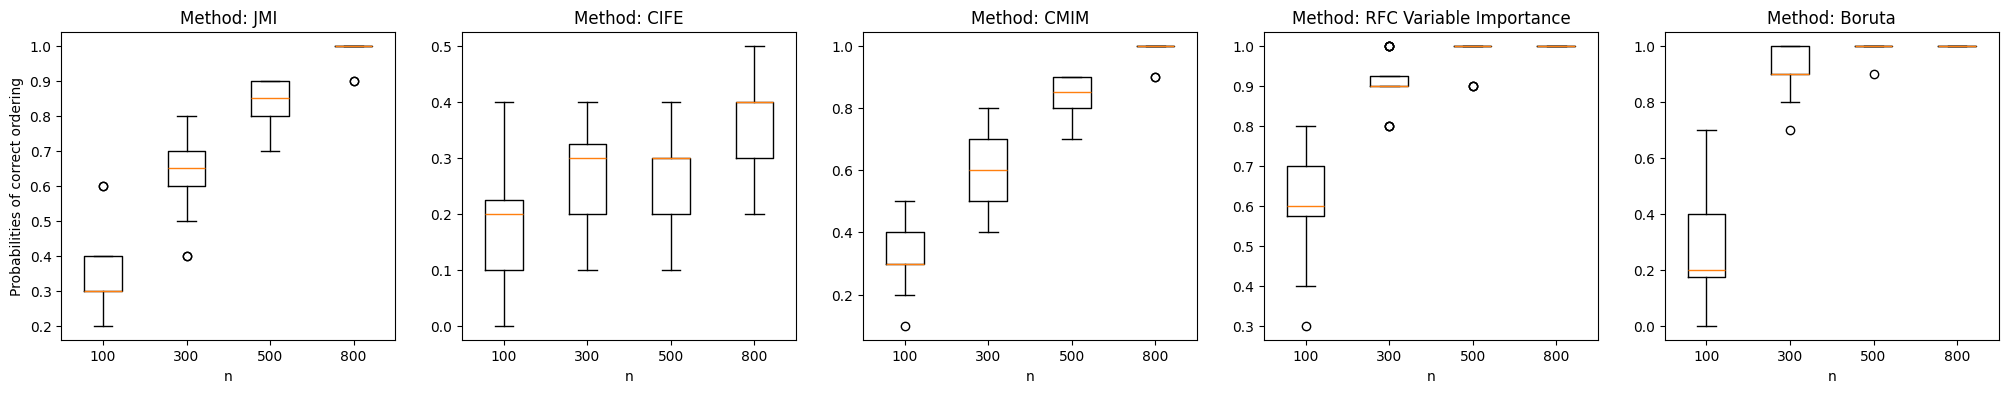

In [46]:
fig ,ax = plt.subplots(ncols=5,figsize=(25,4))
for i in range(5):
    ax[i].boxplot([probas_val[:,i] for probas_val in probas])
    ax[i].set_xticklabels(n_values)
    
    ax[i].set_xlabel('n')
    ax[i].set_title(f'Method: {methods[i]}')
ax[0].set_ylabel('Probabilities of correct ordering')
plt.show()

In [14]:
#Test different p values
p_values = [15,30,50]
probas2 = [perform_experiment_artificial(L,500,p,10) for p in p_values]

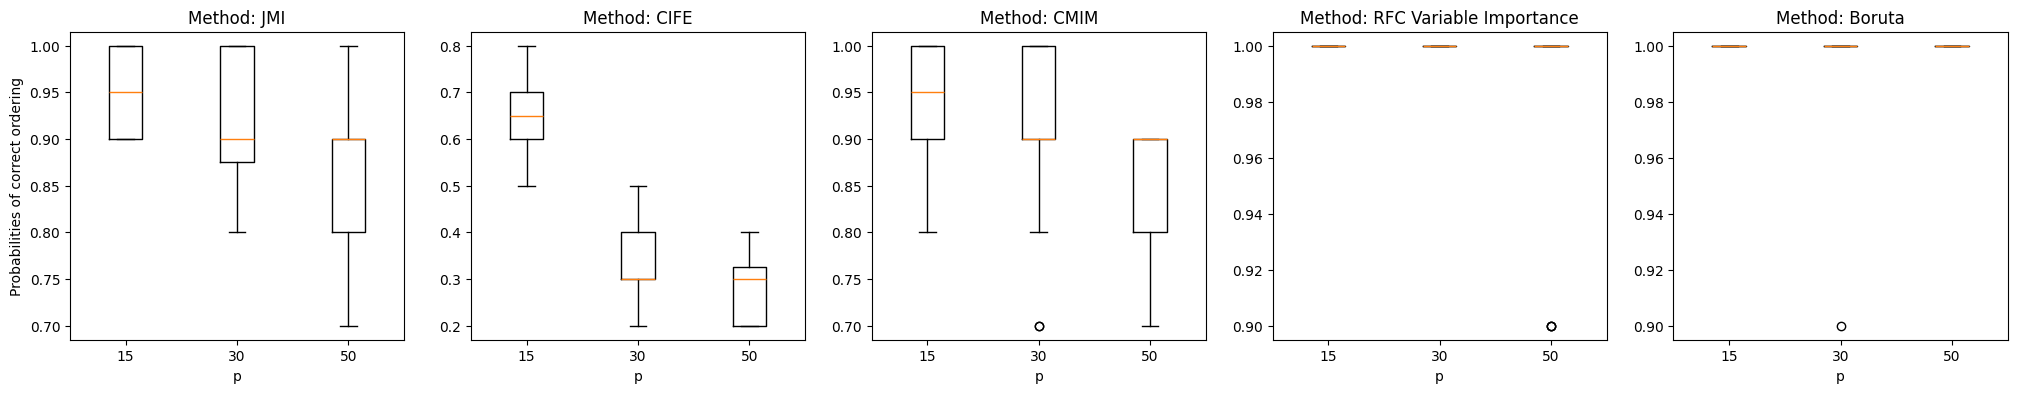

In [45]:
fig ,ax = plt.subplots(ncols=5,figsize=(25,4))
for i in range(5):
    ax[i].boxplot([probas_val[:,i] for probas_val in probas2])
    ax[i].set_xticklabels(p_values)
    
    ax[i].set_xlabel('p')
    ax[i].set_title(f'Method: {methods[i]}')
ax[0].set_ylabel('Probabilities of correct ordering')
plt.show()

In [14]:
#Test different k values
k_values = [10,15,20]
probas3 = [perform_experiment_artificial(L,500,50,k) for k in k_values]

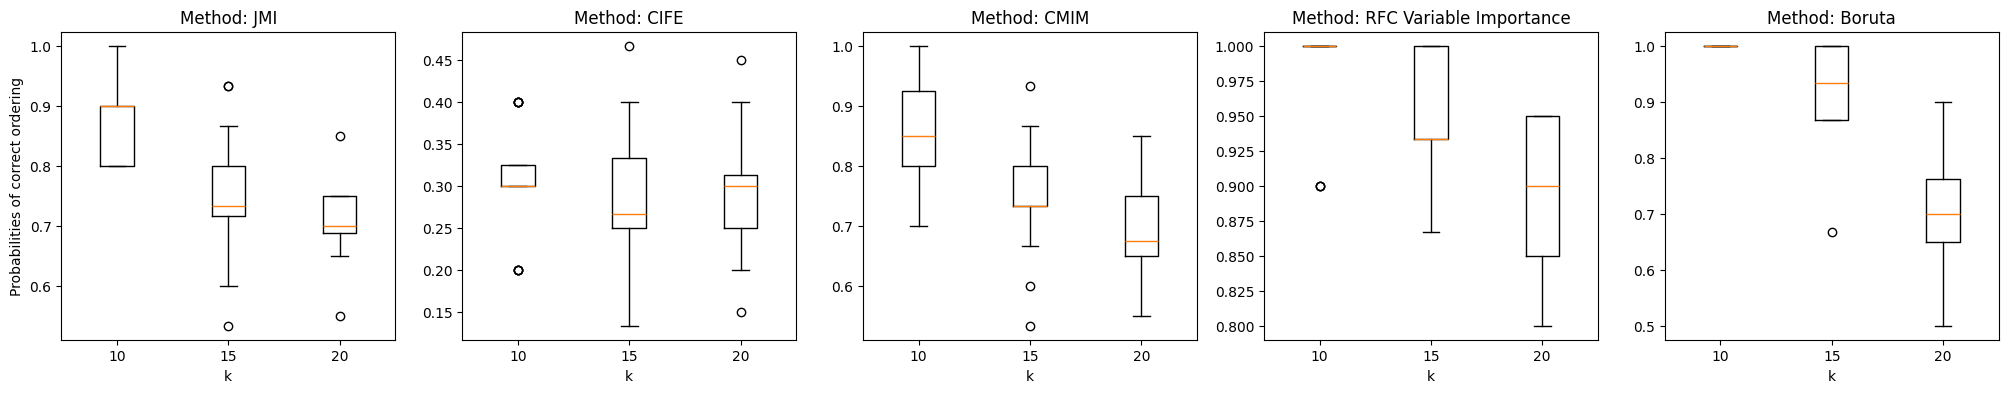

In [44]:
fig ,ax = plt.subplots(ncols=5,figsize=(25,4))
for i in range(5):
    ax[i].boxplot([probas_val[:,i] for probas_val in probas3])
    ax[i].set_xticklabels(k_values)
    
    ax[i].set_xlabel('k')
    ax[i].set_title(f'Method: {methods[i]}')
ax[0].set_ylabel('Probabilities of correct ordering')
plt.show()

# Real-world datasets experiments


In [ ]:
def perform_experiment_real(X,Y,k_vals):
    result_all = {}

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
    k_methods = {'jmi':forward_selection_jmi,'cife':forward_selection_cife, 'rfc':rfc_selection, 'cmim':forward_selection_cmim}
    rfc = RandomForestClassifier(n_estimators=100)
    features = {}
    binary = len(np.unique(Y)) == 2
    rfc.fit(X_train,Y_train)
    Y_pred = rfc.predict(X_test)
    scores = {'accuracy_score':[],'f1_score':[],'roc_auc_score':[]}
    scores['accuracy_score'].append(accuracy_score(Y_test,Y_pred))
    if binary:
        scores['f1_score'].append(f1_score(Y_test,Y_pred))
        scores['roc_auc_score'].append(roc_auc_score(Y_test,rfc.predict_proba(X_test)[:,1]))
    else:
        scores['f1_score'].append(f1_score(Y_test,Y_pred,average='macro'))
        scores['roc_auc_score'].append(roc_auc_score(Y_test,rfc.predict_proba(X_test),multi_class='ovr'))
    results_df = pd.DataFrame(scores,index=['All Features'])
    
    result_all[f'all_{X.shape[1]}'] = results_df
    
    print("\n For All Features")
    print(results_df)
    for k_val in k_vals:
        scores = {'accuracy_score':[],'f1_score':[],'roc_auc_score':[]}
        features[k_val] = {}
        for method_name in k_methods.keys():
            features[k_val][method_name] = k_methods[method_name](X,Y,k_val)
        for i in k_methods.keys():
            rfc.fit(X_train[:,features[k_val][i]],Y_train)
            Y_pred = rfc.predict(X_test[:,features[k_val][i]])
            scores['accuracy_score'].append(accuracy_score(Y_test,Y_pred))
            if binary:
                scores['f1_score'].append(f1_score(Y_test,Y_pred))
                scores['roc_auc_score'].append(roc_auc_score(Y_test,rfc.predict_proba(X_test[:,features[k_val][i]])[:,1]))
            else:
                scores['f1_score'].append(f1_score(Y_test,Y_pred,average='macro'))
                scores['roc_auc_score'].append(roc_auc_score(Y_test,rfc.predict_proba(X_test[:,features[k_val][i]]),multi_class='ovr'))
        results_df = pd.DataFrame(scores,index=k_methods.keys())
        print("\n For k = ",k_val)
        result_all[k_val] = results_df
        print(results_df)
    features_boruta = boruta_selection(X,Y)
    rfc.fit(X_train[:,features_boruta],Y_train)
    Y_pred = rfc.predict(X_test[:,features_boruta])
    scores = {'accuracy_score':[],'f1_score':[],'roc_auc_score':[]}
    scores['accuracy_score'].append(accuracy_score(Y_test,Y_pred))
    if binary:
        scores['f1_score'].append(f1_score(Y_test,Y_pred))
        scores['roc_auc_score'].append(roc_auc_score(Y_test,rfc.predict_proba(X_test[:,features_boruta])[:,1]))
    else:
        scores['f1_score'].append(f1_score(Y_test,Y_pred,average='macro'))
        scores['roc_auc_score'].append(roc_auc_score(Y_test,rfc.predict_proba(X_test[:,features_boruta]),multi_class='ovr'))
    results_df = pd.DataFrame(scores,index=['Boruta'])
    print(f"\n For Boruta. Num of relevant features: {len(features_boruta)}")
    result_all[f'boruta_{len(features_boruta)}'] = results_df
    print(results_df)

    return result_all
    

Breast Cancer Wisconsin

In [ ]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
X_bcw = breast_cancer_wisconsin_diagnostic.data.features 
Y_bcw = breast_cancer_wisconsin_diagnostic.data.targets 
X_bcw = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(X_bcw)
Y_bcw =  np.where(Y_bcw == 'M', 0, 1).flatten()
print(X_bcw.shape)

(569, 30)


In [ ]:
bcw_results = perform_experiment_real(X_bcw,Y_bcw,np.arange(1,22))


 For All Features
              accuracy_score  f1_score  roc_auc_score
All Features         0.97076  0.977169        0.99346

 For k =  1
      accuracy_score  f1_score  roc_auc_score
jmi         0.923977  0.941176       0.967887
cife        0.923977  0.941176       0.965682
rfc         0.923977  0.941176       0.965682
cmim        0.923977  0.941176       0.965682

 For k =  2
      accuracy_score  f1_score  roc_auc_score
jmi         0.947368  0.958904       0.993019
cife        0.947368  0.958904       0.992725
rfc         0.941520  0.954128       0.982731
cmim        0.947368  0.958904       0.993166

 For k =  3
      accuracy_score  f1_score  roc_auc_score
jmi         0.947368  0.958525       0.994489
cife        0.941520  0.953704       0.988022
rfc         0.947368  0.958525       0.990520
cmim        0.970760  0.976744       0.996032

 For k =  4
      accuracy_score  f1_score  roc_auc_score
jmi         0.964912  0.972222       0.986552
cife        0.947368  0.958525       0.

Text(0.5, 1.0, 'breast cancer dataset')

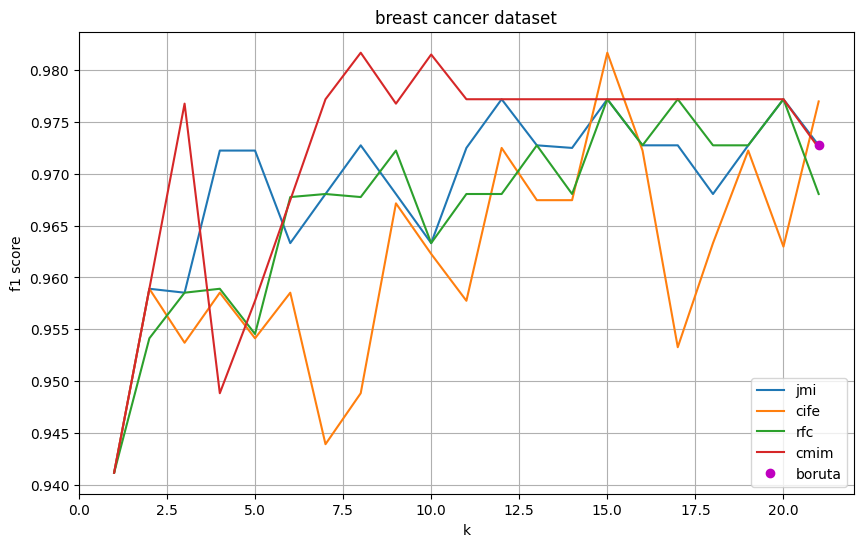

In [ ]:
plot_scores(get_f1_scores(bcw_results))
plt.title('breast cancer dataset')

Red Wine Quality

In [ ]:
pd_wine = pd.read_csv('data/winequality-red.csv')
Y_wine = pd_wine['quality']
X_wine = pd_wine.drop(columns=['quality'])
X_wine = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(X_wine)
print(X_wine.shape)

(1599, 11)


In [ ]:
wine_results = perform_experiment_real(X_wine,Y_wine,np.arange(1,12))


 For All Features
              accuracy_score  f1_score  roc_auc_score
All Features        0.664583  0.364171       0.836245

 For k =  1
      accuracy_score  f1_score  roc_auc_score
jmi         0.510417  0.221979       0.723889
cife        0.510417  0.221979       0.723508
rfc         0.510417  0.221979       0.723508
cmim        0.510417  0.221979       0.723889

 For k =  2
      accuracy_score  f1_score  roc_auc_score
jmi         0.562500  0.288967       0.734123
cife        0.564583  0.289536       0.734054
rfc         0.566667  0.289011       0.733890
cmim        0.562500  0.288624       0.734004

 For k =  3
      accuracy_score  f1_score  roc_auc_score
jmi         0.562500  0.308195       0.653292
cife        0.554167  0.291169       0.735846
rfc         0.535417  0.267362       0.748814
cmim        0.577083  0.307007       0.740219

 For k =  4
      accuracy_score  f1_score  roc_auc_score
jmi         0.575000  0.307191       0.755059
cife        0.583333  0.313607       0.

Text(0.5, 1.0, 'wine dataset')

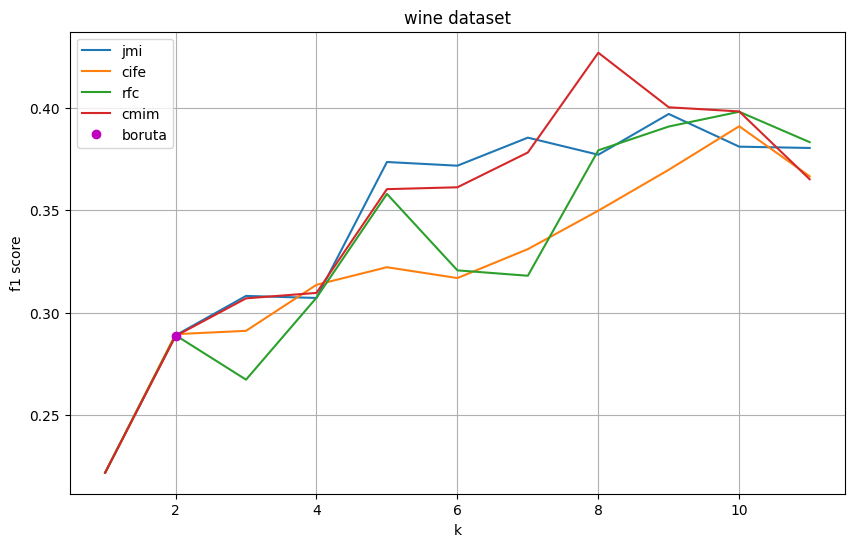

In [ ]:
plot_scores(get_f1_scores(wine_results))
plt.title('wine dataset')

Heart Failure

In [ ]:
pd_heart = pd.read_csv('data/heart.csv')
X_heart = pd_heart.drop(columns=['HeartDisease'])
le = LabelEncoder()
heart_categorical = []
for col in X_heart.columns:
    if X_heart[col].dtype == 'object':
        heart_categorical.append(col)
        X_heart[col] = le.fit_transform(X_heart[col])
X_heart_new_categories = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(X_heart.drop(columns=heart_categorical))
X_heart = np.concatenate((X_heart_new_categories,X_heart[heart_categorical].to_numpy()),axis=1)
Y_heart = pd_heart['HeartDisease'].to_numpy()
print(X_heart.shape)

(918, 11)


In [ ]:
heart_results = perform_experiment_real(X_heart,Y_heart,np.arange(1,12))


 For All Features
              accuracy_score  f1_score  roc_auc_score
All Features        0.873188  0.890966       0.943135

 For k =  1
      accuracy_score  f1_score  roc_auc_score
jmi         0.800725  0.827586       0.801611
cife        0.800725  0.827586       0.801611
rfc         0.800725  0.827586       0.801611
cmim        0.800725  0.827586       0.801611

 For k =  2
      accuracy_score  f1_score  roc_auc_score
jmi         0.793478   0.81672       0.896396
cife        0.793478   0.81672       0.896015
rfc         0.793478   0.81672       0.898465
cmim        0.793478   0.81672       0.898084

 For k =  3
      accuracy_score  f1_score  roc_auc_score
jmi         0.829710  0.852665       0.895851
cife        0.865942  0.888218       0.915587
rfc         0.826087  0.850000       0.896015
cmim        0.836957  0.859813       0.898247

 For k =  4
      accuracy_score  f1_score  roc_auc_score
jmi         0.829710  0.852665       0.901840
cife        0.829710  0.854489       0.

Text(0.5, 1.0, 'heart dataset')

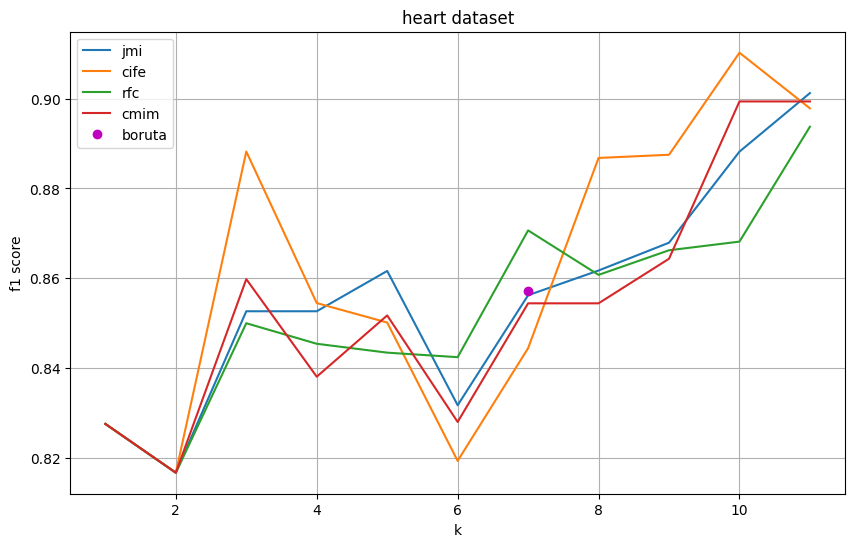

In [ ]:
plot_scores(get_f1_scores(heart_results))
plt.title('heart dataset')

House Prices

In [ ]:
df_house = pd.read_csv('data/kc_house_data.csv')
Y_house = df_house['price'].to_numpy().reshape(-1,1)
X_house = df_house.drop(columns=['price','id','date'])
Y_house = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile').fit_transform(Y_house).flatten()
X_house = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(X_house)
print(X_house.shape)


(21613, 18)


In [ ]:
house_results = perform_experiment_real(X_house,Y_house,np.arange(1,19))


 For All Features
              accuracy_score  f1_score  roc_auc_score
All Features        0.644664  0.643414       0.896536

 For k =  1
      accuracy_score  f1_score  roc_auc_score
jmi         0.392967  0.327988       0.718126
cife        0.392967  0.327988       0.717987
rfc         0.392967  0.327988       0.718126
cmim        0.392967  0.327988       0.718253

 For k =  2
      accuracy_score  f1_score  roc_auc_score
jmi         0.540407  0.547134       0.839756
cife        0.540099  0.546866       0.839505
rfc         0.440623  0.425821       0.752904
cmim        0.540099  0.546866       0.839723

 For k =  3
      accuracy_score  f1_score  roc_auc_score
jmi         0.573257  0.576557       0.860337
cife        0.570173  0.575064       0.860906
rfc         0.479796  0.474906       0.787667
cmim        0.567551  0.572522       0.860590

 For k =  4
      accuracy_score  f1_score  roc_auc_score
jmi         0.590222  0.592445       0.870041
cife        0.603023  0.606710       0.

Text(0.5, 1.0, 'house dataset')

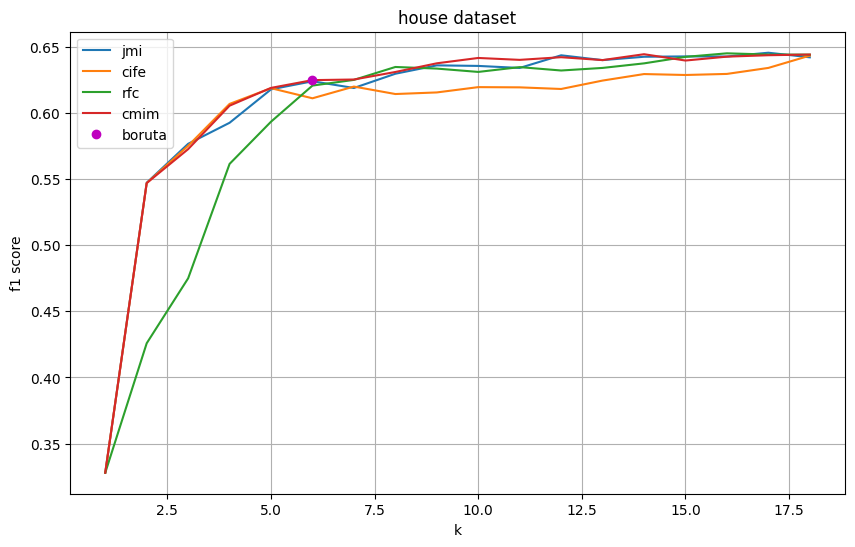

In [ ]:
plot_scores(get_f1_scores(house_results))
plt.title('house dataset')

Adult income

In [ ]:
adult = fetch_ucirepo(id=2) 
X_adult = adult.data.features 
Y_adult = adult.data.targets
Y_adult = np.where(Y_adult == '<=50K', 0, 1).flatten()
le = LabelEncoder()
adult_categorical = []
for col in X_adult.columns:
    if X_adult[col].dtype == 'object':
        adult_categorical.append(col)
        X_adult[col] = le.fit_transform(X_adult[col])
X_adult_new_categories = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(X_adult.drop(columns=adult_categorical))
X_adult = np.concatenate((X_adult_new_categories,X_adult[adult_categorical].to_numpy()),axis=1)
print(X_adult.shape)


(48842, 14)


In [ ]:
adult_results = perform_experiment_real(X_adult,Y_adult,np.arange(1,15))


 For All Features
              accuracy_score  f1_score  roc_auc_score
All Features        0.641439  0.622991       0.693313

 For k =  1
      accuracy_score  f1_score  roc_auc_score
jmi         0.608067  0.577317       0.652255
cife        0.608067  0.577317       0.652326
rfc         0.608067  0.577317       0.652273
cmim        0.608067  0.577317       0.652255

 For k =  2
      accuracy_score  f1_score  roc_auc_score
jmi         0.646694  0.591816       0.703627
cife        0.646352  0.593441       0.703514
rfc         0.632294  0.593543       0.679871
cmim        0.646694  0.591687       0.703464

 For k =  3
      accuracy_score  f1_score  roc_auc_score
jmi         0.650311  0.608915       0.700949
cife        0.646421  0.597092       0.703938
rfc         0.633522  0.612274       0.678714
cmim        0.648400  0.615235       0.701807

 For k =  4
      accuracy_score  f1_score  roc_auc_score
jmi         0.645806  0.612629       0.693701
cife        0.646762  0.618345       0.

Text(0.5, 1.0, 'adult income dataset')

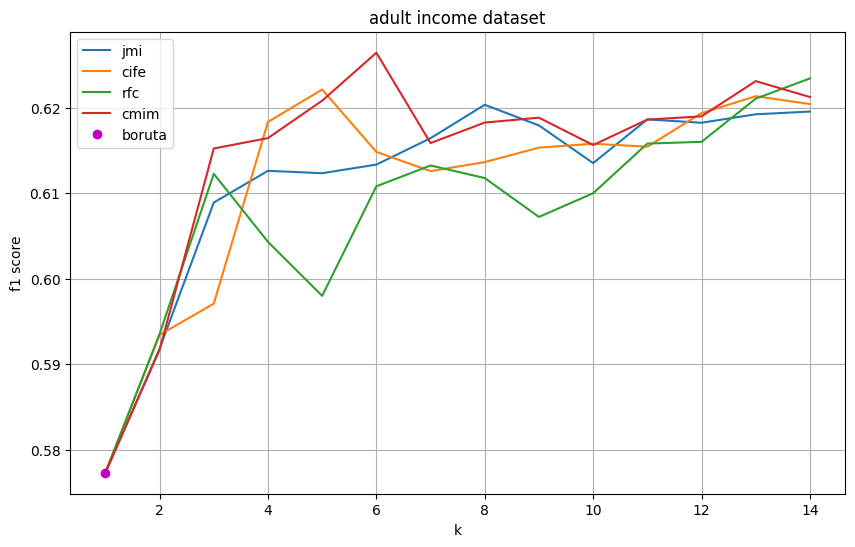

In [ ]:
plot_scores(get_f1_scores(adult_results))
plt.title('adult income dataset')

# Artificial malicious data

In [ ]:
def get_mal_data(n, p):
    X_mal = np.random.randint(0, 10, (n, p-2))
    X_significant = np.random.binomial(1, 0.5, (n,2))
    y = X_significant[:,0] == X_significant[:,1]
    
    X = np.concatenate((X_mal, X_significant), axis=1)

    return X, y


In [ ]:
n = 1000
p = 10
X_mal, y_mal = get_mal_data(n, p)

In [ ]:
mal_results = perform_experiment_real(X_mal,y_mal,np.arange(1,p+1))


 For All Features
              accuracy_score  f1_score  roc_auc_score
All Features        0.976667  0.975089       0.991097

 For k =  1
      accuracy_score  f1_score  roc_auc_score
jmi         0.496667  0.551929       0.532252
cife        0.496667  0.551929       0.529314
rfc         0.480000  0.648649       0.517628
cmim        0.496667  0.551929       0.534255

 For k =  2
      accuracy_score  f1_score  roc_auc_score
jmi         0.560000  0.568627       0.581909
cife        0.546667  0.549669       0.588275
rfc         1.000000  1.000000       1.000000
cmim        0.560000  0.571429       0.583689

 For k =  3
      accuracy_score  f1_score  roc_auc_score
jmi         0.556667  0.539792       0.565839
cife        0.536667  0.538206       0.559651
rfc         1.000000  1.000000       1.000000
cmim        0.546667  0.540541       0.565705

 For k =  4
      accuracy_score  f1_score  roc_auc_score
jmi         0.513333  0.532051       0.551037
cife        0.480000  0.462069       0.

Text(0.5, 1.0, 'artificial noisy dataset')

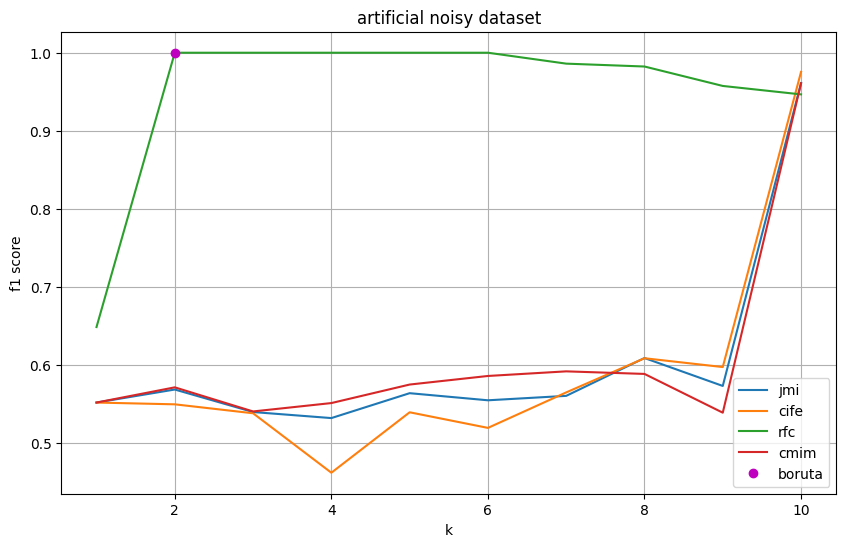

In [ ]:
plot_scores(get_f1_scores(mal_results))
plt.title('artificial noisy dataset')